### Predicting Probability of Arrest in Cases of Use of Force by Police
Andrew Gibbs-Bravo | 180028746 | INM430

Notebook Sections: <br>
* [Import and Clean Data](#Import-and-Clean-Data)
    - Merge datasets, examine data, fill missing values, change data types, engineer features
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - Prepare data to be exported to Tableau, explore relationships through charts and export to excel 
* [Transformation Functions](#Transformation-Functions)
    - Build required functions to transform the data including train / test split, standardization, encoding categorical variables, dimensionality reduction, etc. for embedded pipeline
* [Classification Algorithms](#Classification-Algorithms)
    - Develop LightGBM and Logistic Regression functions for prediction
* [Develop Embedded Pipeline](#Develop-Embedded-Pipeline)
    - Transformation pipeline converts raw data subject to model configuration parameters in order to be able to apply classification algorithms
* [Pipeline Application and Gridsearch](#Pipeline-Application-and-Gridsearch)
    - Evaluate random subset of model configurations by gridsearch due to resource constraint 
* [Model Selection and Evaluation](#Model-Selection-and-Evaluation)
    - Select optimal model configuration based on recorded cross validation results, tune hyperparameters, and then evaluate performance
* [Other Analysis](#Other-Analysis)
    - Analyze correlation and visualization of dimensionality reduction using MCA


# Import and Clean Data

#### Commentary
The purpose of this section is to understand the dataset and preprocess the data to ensure no missing values, duplicates, or incorrect data. It also merges supplemental crime statistic data from another dataset as a proxy for borough criminality.

In [27]:
# Import libraries, change working directory to where files are located, and turn warnings off
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

import os
os.chdir('C:/Users/AGB/Desktop/Data_Science_MSc/Principles_DS/Project')
print(os.getcwd())

pd.options.mode.chained_assignment = None  # default='warn'

import random

C:\Users\AGB\Desktop\Data_Science_MSc\Principles_DS\Project


In [112]:
import chardet

# Enter filename(s), designed for concatenating dataframes with the same columns / structure
filename = ['MPS Use of Force - FY17-18.csv','MPS Use of Force - FY18-19.csv']
raw_df = pd.DataFrame([])

# Merge the files into the same dataframe for later analysis
for file in filename:     
    # Looks at the first ten thousand bytes to determine the character encoding for dataframe import
    with open(file, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(10000))
    
    # Note: low memory option will enable columns with mixed data types to be asserted later
    tempdf = pd.read_csv(file,encoding=result['encoding'], low_memory=False)
    raw_df = pd.concat([raw_df,tempdf])

raw_df.reset_index(drop=True,inplace=True)

In [113]:
# Create copy for quick re-loading during analysis
df = raw_df.copy()

# Sample dataframe to improve calculation time until finalized
#df = df.sample(frac=0.2, random_state=10)

# Can alternatively use first n rows which is useful in determining duplicates as data is ordered by time
#df = df.loc[1:15000,:]
original_df_size = len(df)

In [114]:
# Preliminary review of data structure and columns
print(df.info())
columns = np.array(df.columns)

# Display all columns in dataframe for EDA & preprocessing, commented out for submission
#with pd.option_context("display.max_rows", len(columns)):
#    display(df.head().transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103482 entries, 0 to 103481
Columns: 271 entries, IncidentDate to Outcome: Other
dtypes: float64(22), object(249)
memory usage: 214.0+ MB
None


## Preprocessing Notes
Went through each column individually and made notes during initial preprocessing:

Global
- Remove duplicates based on equal location, time, and gender (and possibly age)
- Convert all 'Yes' / 'No' to 1 / 0

Feature Specific
- IncidentDate: will need to be converted to date-time format for further analysis
- Incident Location fields: are one-hot encoded and should be merged to facilitate further analysis
- ThreatenedWithWeapon and AssaultedWithWeapon should look closely at NaNs and probably convert to No
    - Then convert field to binary 
- Impact Factor fields: need to be merged in order to facilitate varying encoding between one-hot and mean-encoding
- Reason For Force: need to be merged in order to facilitate varying encoding between one-hot and mean-encoding
- CarryingCED: look closely at NaNs and probably convert to No
- Need to understand the relationship between tactic n and effective n 
    - Convert to number of tactics used
- CED variables should probably have NaN converted to No
- CED data should be heavily aggregated as is very sparse
- Outcome fields: drop all except Outcome:Arrested

Record type of statistic and note categorical variables

Categorical Variables
- [IncidentLocation, Borough, PrimaryConduct, ImpactFactor, ReasonForForce, MainDuty, Tactic 1, SubjectEthnicity, StaffInjuryLevel, SubjectNatureOfInjury]

Ordinal Variables
- [Tactic 1-etc?, SubjectAge]

Binary Variables
- [AssaultedBySubject, ThreatenedWithWeapon, AssaultedWithWeapon, SingleCrewed, TrainedCED, CarryingCED, CED Data, Firearms Aimed, Firearms Fired, SubjectGender, PhysicalDisability, MentalDisability, StaffInjured, StaffInjuryIntentional, StaffMedProvided, SubjectInjured, SubjectMedOffered, SubjectMedProvided]

In [90]:
# Extract date features for later analysis
df['IncidentYear'] = pd.to_datetime(df['IncidentDate']).dt.year
df['IncidentMonth'] = pd.to_datetime(df['IncidentDate']).dt.month
df['IncidentWeekday'] = pd.to_datetime(df['IncidentDate']).dt.weekday
df['IncidentHour'] = pd.to_datetime(df['IncidentTime']).dt.hour
df['IncidentHour'].replace(0,24,inplace=True)

# Create feature of four segments of day
df['TimeofDay'] = pd.cut(df['IncidentHour'], 4, labels=['Early_Morning','Morning','Afternoon','Night'])

In [6]:
# One-hot-encoded Features Preprocessing

# List one-hot-encoded features needing merging with new labels
one_hot_vars = [['Incident Location: ','IncidentLocation'], ['Impact Factor: ','ImpactFactor'], 
                ['Reason for Force: ','ReasonForForce']]

def merge_one_hot(input_feature, output_label):
    # Create separate dataframe with only values then drop from main dataframe
    merged_df = df.loc[:, df.columns.str.contains(input_feature)]
    df.drop(merged_df.columns, axis=1, inplace=True)

    # First need to confirm theory that are one-hot-encoded (mutually exclusive locations)
    binary_map = {'Yes':1,'No':0} 
    merged_df = merged_df.apply(lambda x: x.map(binary_map))
    
    print(input_feature)
    print("Confirm max across rows equals 1: ", max(merged_df.sum(1) == 1))
    
    # Create new renamed column to consolidate all other rows for easier visualization and manipulation later
    # Remove merged title from headers
    merged_df.columns = [i.replace(input_feature,"") for i in merged_df.columns]

    # Remove old incident location columns and add consolidated one
    df[output_label] = [np.argmax(merged_df.iloc[i], axis=1) for i in range(len(merged_df))]
    
for var in one_hot_vars:
    merge_one_hot(var[0],var[1])

Incident Location: 
 Confirm max across rows equals 1:  True


C:\Users\AGB\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


Impact Factor: 
 Confirm max across rows equals 1:  True
Reason for Force: 
 Confirm max across rows equals 1:  True


#### Commentary
The dataset recorded incidents involving multiple officers and one subject as multiple incidents which would decrease prediction accuracy for new incidents. We therefore need to remove duplicate instances. Incidents with matching physical features such as date, area, location, and demographic features were selected as police may report different subjective variables such as reason for force or primary conduct. Aggregated time of day was used rather than hour to account for differences in police reporting windows.

In [7]:
# Drop duplicate values where critical fields are equal to one another
df.drop_duplicates(subset=['IncidentDate','Borough','IncidentLocation','SubjectEthnicity','SubjectGender','TimeofDay',
                           'PrimaryConduct','SubjectAge'],inplace=True)
print('Dataframe size after removal of duplicates: {} ({:.2f} of total)'.format(len(df), len(df)/original_df_size))

# Drop original date fields as relevant fields have been converted into date-time
df.drop(['IncidentDate','IncidentTime'],axis=1,inplace=True)

# Drop transgender subjects to simplify given low count (271 / ~90,000 occurrences)
df = df[df['SubjectGender'] != 'Transgender']

Dataframe size after removal of duplicates: 90088 (0.87 of total)


#### Commentary
Need to convert tactic features to "some hot encoded" features thereby creating assumption that order of tactics is less important than which tactics were performed and the number of tactics. CED is very sparse and missing values appear to be non-occurrences so were converted to zeros. Then need to fill missing values for binary features.

In [8]:
# Convert Tactic to to some hot encoding
from sklearn.preprocessing import MultiLabelBinarizer

tactic = df.loc[:, df.columns.str.contains('Tactic')]

# Instantiate empty tactic list and iterate through tactic number features until it is empty
# Then append each tactic to the temporary tactic list 
tactic_list = []
for i in range(len(tactic)):
    temp_tactic_list = []

    for j in tactic.iloc[i,:]:
        if pd.isnull(j):
            break
        else:
            temp_tactic_list.append(j)
    tactic_list.append(temp_tactic_list)

# Create feature for total number of tactics applied 
df['NumTactics'] = [len(i) for i in tactic_list]

# Create "some hot encoded" features thereby creating assumption that order of tactics is less important
    # than which tactics were performed and the number of tactics
mlb = MultiLabelBinarizer()

df = df.join(pd.DataFrame(mlb.fit_transform(tactic_list),
                          columns=mlb.classes_,
                          index=df.index))

# Remove original tactic information 
df.drop(tactic.columns,axis=1,inplace=True)
df.drop(df.loc[:,df.columns.str.contains('Effective')].columns,axis=1,inplace=True)

In [9]:
# Rename columns for easier further use
df.rename(columns = {'Outcome: Arrested':'Arrested', 'Firearms Aimed':'FirearmsAimed',
                     'Firearms Fired':'FirearmsFired'}, inplace = True)

# Drop other outcome columns as objective is to create a binary classifier between arrested and other
df.drop(df.loc[:,df.columns.str.contains('Outcome:')].columns,axis=1,inplace=True)

In [10]:
# CED Engineering: a large number of features relate to presence and use of Conducted Energy Devices (CED)

# Can drop serial number columns as provide no information
df.drop(['CED Device Serial No', 'CED Fired Cartridge Number', 'CED2 Fired Cartridge Number',
        'CED3 Fired Cartridge Number', 'CED4 Fired Cartridge Number'],axis=1,inplace=True)

# Create CED dataframe to process CED features directly more easily
CED = df.loc[:,df.columns.str.contains('CED')].copy()

binary_map = {'Yes':1,'No':0}

for i in CED:
    try:
        CED[i].replace(binary_map, inplace=True)
    except:
        CED[i].astype('str').replace(binary_map, inplace=True)

# After inspecting the dataframe can conclude that missing values are non-occurrences,
    # therefore can fill with zeros
CED.fillna(0,inplace=True)

# One-hot encode 'CED Used' into CED dataframe
CED = CED.join(pd.get_dummies(df['CED Used']),how='outer')
CED.drop('CED Used',axis=1,inplace=True)

# Convert all to integer given no float values
float_feats = CED.select_dtypes('float').columns
for i in float_feats:
    CED[i] = CED[i].astype('int32')

# Can then drop all CED related features from main dataframe as dimensionality reduced
    # features will be added back instead as features are very sparse and correlated
df.drop(df.loc[:,df.columns.str.contains('CED')].columns,axis=1,inplace=True)

In [11]:
#Fill remaining null values

# Identify binary variables to be converted to 1/0 and fill empty values with zero where applicable
binary_variables = ['AssaultedBySubject', 'ThreatenedWithWeapon', 'AssaultedWithWeapon',
                    'SingleCrewed', 'FirearmsAimed', 'FirearmsFired','PhysicalDisability',
                    'MentalDisability', 'StaffInjured', 'StaffInjuryIntentional', 
                    'StaffMedProvided','SubjectInjured', 'SubjectMedOffered',
                    'SubjectMedProvided','Arrested']

# Instantiate array to identify features requiring additional manual processing
additional_processing_req = []

for i in binary_variables:
    # First checks if set of values is below or equal to 3 (Yes, No, NaN)
    # Has two encoding techniques as some features have different datatypes
    # If has more than 3 variables then additional processing is required
    if len(set(df[i]))<=3:
        try:
            df[i].replace(binary_map, inplace=True)
        except:
            df[i].astype('str').replace(binary_map, inplace=True)
            
        df[i].fillna(0,inplace=True)
    else:
        additional_processing_req.append(i)

# Additional processing for binary variables without only yes / no information
print(additional_processing_req)

# Three features were idenfied as requiring manual processing
df['ThreatenedWithWeapon'] = np.where(df['ThreatenedWithWeapon'].notnull(),1,0)
df['AssaultedWithWeapon'] = np.where(df['AssaultedWithWeapon'].notnull(),1,0)
df['SubjectInjured'].loc[df['SubjectInjured'].isnull() == True] = 'Unknown'

# Encode gender as male == 1 and female == 0
df['SubjectGender'] = np.where(df['SubjectGender'] == 'Male',1,0)
df.rename(columns = {'SubjectGender':'MaleSubject'}, inplace = True)

# Convert accidental binary datatypes which were recorded as float datatypes
float_feats = df[binary_variables].select_dtypes('float').columns
for i in float_feats:
    df[i] = df[i].astype('int32')

['ThreatenedWithWeapon', 'AssaultedWithWeapon', 'SubjectInjured']


In [12]:
# Fill null values in categorical features
df['StaffInjuryLevel'].fillna('None',inplace=True)
df['SubjectNatureOfInjury'].loc[df['SubjectInjured'] == 'Unknown'] = 'Unknown'
df['SubjectNatureOfInjury'].fillna('None',inplace=True)

#### Commentary
Add average of number of years of crime rate by borough to capture longer term proxy for criminality. The hypothesis is there are likely to be higher arrest rates in areas with more crime and particularly more violent crime.

In [13]:
# Augment original data with offence rates per capita as a proxy for criminality in borough
borough_offence_rates = pd.read_csv('all_recorded_offences_per_capita.csv')

# Subset of all_recorded_offences_per_capita dataset which represents proportion of offences related to: 
# Violence against the person, sexual offences, robbery, burglary, and theft and handling
borough_violent_offence_proportion = pd.read_csv('violent_offences_per_capita.csv')

# Change borough labels to ensure consistency between data frames
borough_offence_rates.replace({'Westminster':'City of Westminster'}, inplace=True)
borough_violent_offence_proportion.replace({'Westminster':'City of Westminster'}, inplace=True)

# Create helper function to append the average of n years of offense rates to the main dataframe  
def add_offence_data(input_df,avg_n_years,feature_name):
    global df
    
    input_df[feature_name] = input_df.iloc[:,-avg_n_years:].mean(axis=1)
    input_df = input_df[['Borough',feature_name]]
    df = df.merge(input_df,how='left')
    df[feature_name].fillna(
        input_df[feature_name].loc[input_df['Borough'] == 'Outer London'].iloc[0],inplace=True)
    
add_offence_data(borough_offence_rates,3,'AvgOffenceRate')
add_offence_data(borough_violent_offence_proportion,3,'AvgViolentOffenceRate')

In [14]:
# Inspect the transformed dataset including ensuring datatypes are as expected 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89821 entries, 0 to 89820
Data columns (total 53 columns):
Borough                                                                           89821 non-null object
PrimaryConduct                                                                    89821 non-null object
AssaultedBySubject                                                                89821 non-null int64
ThreatenedWithWeapon                                                              89821 non-null int32
AssaultedWithWeapon                                                               89821 non-null int32
MainDuty                                                                          89821 non-null object
SingleCrewed                                                                      89821 non-null int64
FirearmsAimed                                                                     89821 non-null int64
FirearmsFired                                                   

In [15]:
CED.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89821 entries, 0 to 103481
Columns: 167 entries, TrainedCED to X26 Taser
dtypes: int32(164), int64(1), uint8(2)
memory usage: 60.2 MB


In [16]:
# Save down the dataframes locally so they can be easily reloaded when doing later analysis
df.to_csv('Use_of_Force_Processed.csv', index=False)
CED.to_csv('CED_Processed.csv', index=False)

# Exploratory Data Analysis

#### Commentary
The purpose of this section is to gain a better understanding of the relationships between variables and the arrest rate in addition to interrelationships. Geographic data is better examined in Tableau and therefore the latitude and longitude were taken by borough from the 2011 census in order to be able to potentially add other census information in analysis although did not have time. 

In [2]:
# Load the datasets
df = pd.read_csv('Use_of_Force_Processed.csv')
CED = pd.read_csv('CED_Processed.csv')

In [3]:
# Create dataframe for Tableau in order to explore geographic relationships more easily
tableau_df = df.copy()

# Load census 2011 census data for latitude and longitude data by borough
# Can also use the census data in later analysis although was unable to do this given time constraint
raw_coordinate_df = pd.read_csv('oac2011_london_census.csv', low_memory=False)

coordinate_df = raw_coordinate_df[['Local Authority','oa_lat','oa_lon']].copy()
coordinate_df.columns = ['LocalAuthority','Latitude', 'Longitude']

coordinate_df.dropna(inplace=True)
coordinate_df.reset_index(drop=True,inplace=True)

# Calculate the mean latitude and longitude by local authority
coordinate_df = coordinate_df.groupby(by='LocalAuthority').mean()

# Rename Westminster to remain consistent with original dataframe
coordinate_df.rename(index={'Westminster':'City of Westminster'},inplace=True)
coordinate_df.reset_index(inplace=True)

# Merge and export the data to a csv for import to tableau (sample of analysis is contained in report)
tableau_df = tableau_df.merge(coordinate_df,left_on='Borough',right_on='LocalAuthority')
tableau_df.drop('LocalAuthority', axis=1, inplace=True)

tableau_df.to_csv('Use_of_Force_Tableau.csv', index=False)

In [4]:
# Create dataframe for arrested and not arrested to perform comparisons and charting more easily
arrested_df = df[df['Arrested']==1]
not_arrested_df = df[df['Arrested']==0]

# Create function for charting bar chart 
def categorical_bar_chart(labels, vals, title, width=0.8):
    n = len(vals)
    _labels = np.arange(len(labels))
    for i in range(n):
        plt.bar(_labels - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_labels, labels, rotation='vertical')
    
    plt.title(title)
    plt.ylabel('Proportion of Total')
    plt.legend(('Arrested', 'Not Arrested'))

# Create function for charting scatter plot
def scatter_plot(array1_norm, array2_norm, title):
    plt.title(title)
    plt.scatter(array1_norm,array2_norm);
    line = np.linspace(0.0,max(array1_norm)+.01,10)
    plt.plot(line,line, '--r');
    plt.ylabel('Proportion of Total Not Arrested')
    plt.xlabel('Proportion of Total Arrested')

    for i, txt in enumerate(array1_norm.index):
        plt.annotate(txt, (array1_norm.iloc[i], array2_norm.iloc[i]))

# Calculate the differences between datasets for a given feature
# Are focusing on the differences between the means of the various features
    # and want to focus on only the most extreme instances
# Given some features have a high number of unique values (i.e. borough) function accepts
    # a maximum number of elements
def calculate_differences(feature, chart, max_elements = 10):
    array1 = arrested_df[feature]
    array2 = not_arrested_df[feature]
    
    array1_norm = array1.value_counts()/len(array1)
    array2_norm = array2.value_counts()/len(array2)
    
    # Ensure arrays have the same elements for comparison
    shared_elements = array1_norm.index.intersection(array1_norm.index)
    array1_norm = array1_norm.loc[shared_elements]
    array2_norm = array2_norm.loc[shared_elements]
    
    assert len(array1_norm) == len(array2_norm), 'Arrays are not equal'
    
    # In cases with more groupings than max_elements,include only most extreme elements
    delta = (array1_norm) - (array2_norm)
    delta.sort_values(ascending=False, inplace=True)

    if len(array1_norm) > max_elements: 
        largest_difference = pd.concat([delta[:min(len(array1),int(max_elements/2))],
                                        delta[-min(len(array1),int(max_elements/2)):]])
    else:
        largest_difference = delta
        
    # Select which chart output is preferred (between scatter and bar)
    if chart.lower() == 'bar':
        difference_array = [array1_norm.loc[largest_difference.index], array2_norm.loc[largest_difference.index]]
        return categorical_bar_chart(largest_difference.index,difference_array,feature)
    
    else:
        return scatter_plot(array1_norm.loc[largest_difference.index], array2_norm.loc[largest_difference.index], feature)

#### Commentary
Select features for examination, then apply previous function with scatter plot and bar chart. Charts represent the proportion of the total arrested and not arrested with a given characteristic. If there was no variation between the populations then the proportions should be similar, and the point should be close to the red line. The further the point is the stronger the difference. This shows that impact factor, borough, primary conduct and incident hour are particularly important.

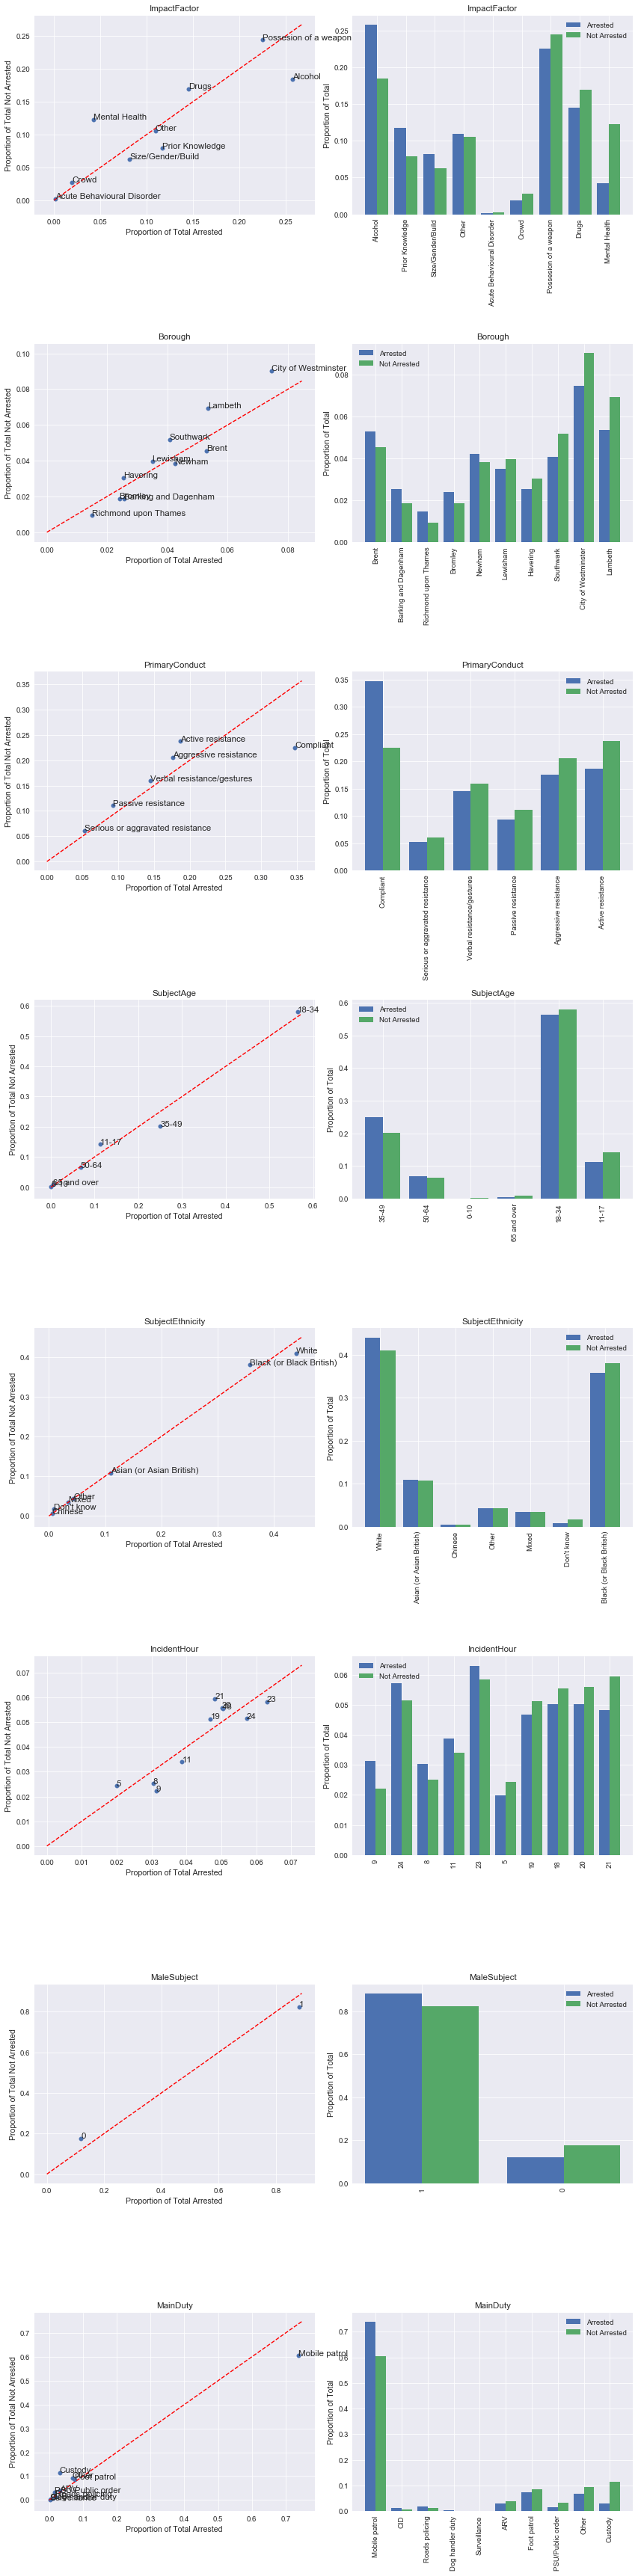

In [28]:
# Feature list of categorical variables to compare
features = ['ImpactFactor', 'Borough', 'PrimaryConduct', 'SubjectAge',
            'SubjectEthnicity', 'IncidentHour', 'MaleSubject', 'MainDuty']

# Create layout for multiple charts and plot using for loop
def examine_features(features_list):
    columns = 2
    rows = len(features_list)
    fig = plt.figure(figsize=(12, 6*rows))
    j = 0

    for i in range(rows*columns):
        fig.add_subplot(rows, columns, i+1)

        if i % 2 == 0:
            calculate_differences(features_list[j], 'scatter')
        else:
            calculate_differences(features_list[j], 'bar')
            j += 1

    plt.tight_layout()
    plt.show()
    
examine_features(features)

#### Commentary
Given importance of time, wanted to examine the relationship between time period and arrest rate which is easier done in Excel. Exported data to be used in charts. Same procedure was followed for incident location data.

In [6]:
# Create outputs to examine arrests / non-arrests by time in Excel charts
# Incident Hour
print(df.groupby(['IncidentHour','Arrested']).count()['Borough'].unstack().transpose().to_string())
print()

# Incident Weekday
print(df.groupby(['IncidentWeekday','Arrested']).count()['Borough'].unstack().transpose().to_string())
print()

# Incident Month
print(df.groupby(['IncidentMonth','Arrested']).count()['Borough'].unstack().transpose().to_string())


IncidentHour    1     2     3     4     5    6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24
Arrested                                                                                                                                                   
0             1511  1256  1132   816   741  417   579   766   676   937  1034  1173  1202  1291  1704  1829  1773  1687  1561  1703  1813  1491  1776  1566
1             3042  2496  2065  1503  1183  752  1176  1808  1862  1871  2301  2358  2300  2596  3518  3712  3288  2989  2783  2979  2860  2804  3744  3397

IncidentWeekday     0     1     2     3     4     5     6
Arrested                                                 
0                3914  4217  4413  4436  4430  4869  4155
1                7750  8094  8507  8473  8765  9360  8438

IncidentMonth    1     2     3     4     5     6     7     8     9     10    11    12
Arrested                                                

In [7]:
# Create outputs to examine arrests / non-arrests by incident location in Excel charts
incident_location_chart = df[['IncidentLocation','Arrested']].groupby(['IncidentLocation']).sum()
incident_location_chart.reset_index(inplace=True)
incident_location_chart['TotalIncidents'] = df[['IncidentLocation','Arrested']].groupby(['IncidentLocation']).count().values
incident_location_chart

,IncidentLocation,Arrested,TotalIncidents
0,Ambulance,68,274
1,Custody Block,3310,7852
2,Dwelling,12443,16644
3,Hospital/A&E (non-mental-health setting),867,1797
4,Licensed Premises,646,862
5,Mental Health Setting,115,550
6,"Open ground (e.g. park, car park, field)",1852,2867
7,Other,2859,4117
8,Police station (excluding custody block),836,1067
9,Police vehicle with prisoner handling cage,235,297


# Transformation Functions

#### Commentary
The purpose of this section is to create the necessary function to be able to build the embedded pipeline. Each function has technical information commented throughout although verbal commentary will be deferred until the embedded pipeline to avoid duplication.

In [8]:
# Sample dataframe to improve calculation time until finalized then comment out
df = df.sample(frac=0.60, random_state=34)
CED = CED.loc[df.index]

# Drop features which were only used for visualizations
df.drop(['IncidentYear'],axis=1,inplace=True)

In [9]:
from sklearn.model_selection import train_test_split

# Create functions to initialize train / test split for model testing and CV split for model configuration
def initialize_train_test(target, test_proportion):
    
    # Split data into training and test by desired proportion
    y = df[target].copy()
    X = df.loc[:,df.columns !=target].copy()
    return train_test_split(X, y, test_size = test_proportion, random_state = 34)

def initialize_CV(X_train_input, y_train_input, test_proportion):
    return train_test_split(X_train_input, y_train_input, test_size=test_proportion, random_state = 34)

In [10]:
# Function takes dataframe of list of categorical features and adds desired encoding based 
    # on "encoding" parameter
# If encoding parameter is set to random then it randomly selects from encoding options 
def catvar_encoding_list(input_df, encoding_options, encoding='one-hot'):
    input_df['encoding'] = [random.choice(encoding_options) if encoding == 'random' else encoding
                                    for _ in range(len(input_df))]

# Applies encoding to categorical feature depending on selected model
def categorical_encoding(X_train_input, X_test_input, model):
    if model == 'one-hot':
        X_train_output = pd.get_dummies(X_train_input)
        X_train_output.columns = [X_train_input.name+': '+x for x in X_train_output.columns]
        
        X_test_output = pd.get_dummies(X_test_input)
        X_test_output.columns = [X_test_input.name+': '+x for x in X_test_output.columns]
        return X_train_output, X_test_output
    
    elif model == 'mean-encode':
        mean_encodings = df[[X_train_input.name,target]].loc[X_train_input.index].groupby(X_train_input.name).mean()
        X_train_output = X_train_input.to_frame().merge(mean_encodings,how='left',on=X_train_input.name)
        X_test_output = X_test_input.to_frame().merge(mean_encodings,how='left',on=X_test_input.name)
        return X_train_output[target].values, X_test_output[target].values
    
    else: print(X_train_input.name,' not encoded')

In [11]:
from sklearn.decomposition import PCA
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import mca

# Dimensionality reduction function: creates dataframe of principal components, weights, etc. resulting
    # from the selected model given the desired number of components
# Outputs summary statistics such as explained variance where applicable
def dimensionality_reduction(X_train_input, X_test_input, model, output_name, n_components):
    if model == 'PCA':
        pca = PCA(n_components=n_components)
        pca.fit(X_train_input)
        print(output_name,' PCA Output:')
        print(pca.explained_variance_ratio_, 'Total:', 
              pca.explained_variance_ratio_.sum().round(2))
        X_train_output = pd.DataFrame(pca.transform(X_train_input),columns = 
                                      [output_name+'_PC'+str(p+1) for p in range(n_components)],
                                      index=X_train_input.index)
        X_test_output = pd.DataFrame(pca.transform(X_test_input),columns = 
                                     [output_name+'_PC'+str(p+1) for p in range(n_components)],
                                     index=X_test_input.index)
        return X_train_output, X_test_output
    
    elif model == 'Autoencoder':
        ncol = X_train_input.shape[1]
        input_dim = Input(shape = (ncol,))

        # Define the number of encoder dimensions
        encoding_dim = n_components

        # Define the encoder layer
        encoded = Dense(encoding_dim, activation = 'relu')(input_dim)

        # Define the decoder layer
        decoded = Dense(ncol, activation = 'tanh')(encoded)

        # Combine the encoder and decoder into a model
        autoencoder = Model(inputs = input_dim, outputs = decoded)

        # Configure and train the autoencoder
        autoencoder.compile(optimizer = 'adam', loss = 'mse')
        autoencoder.fit(X_train_input, X_train_input, epochs = 75, batch_size = 128, shuffle = True,
                        validation_data = (X_test_input, X_test_input),verbose = 0)

        # Use the encoder to extract the reduced dimension from the autoencoder
        encoder = Model(inputs = input_dim, outputs = encoded)
        encoded_input = Input(shape = (encoding_dim, ))

        X_train_output = pd.DataFrame(encoder.predict(X_train_input),columns = 
                                      [output_name+'_Node'+str(p+1) for p in range(n_components)],
                                      index=X_train_input.index)
        X_test_output = pd.DataFrame(encoder.predict(X_test_input),columns = 
                                     [output_name+'_Node'+str(p+1) for p in range(n_components)],
                                     index=X_test_input.index)
        return X_train_output, X_test_output
    
    elif model == 'LDA':
        try:
            lda = LatentDirichletAllocation(n_components=n_components, random_state=34,learning_method='batch')
            lda.fit(X_train_input) 
            X_train_output = pd.DataFrame(lda.transform(X_train_input),columns = 
                                          [output_name+'_LDA'+str(p+1) for p in range(n_components)],
                                          index=X_train_input.index)
            X_test_output = pd.DataFrame(lda.transform(X_test_input),columns = 
                                         [output_name+'_LDA'+str(p+1) for p in range(n_components)],
                                         index=X_test_input.index)
            return X_train_output, X_test_output
        
        except ValueError:
            print('No dimensionality reduction performed - contains negative values: ', output_name)
            return X_train_input, X_test_input
    
    elif model == 'NMF':
        try:
            nmf = NMF(n_components=n_components, solver="mu", max_iter=400, random_state=34)
            nmf.fit(X_train_input) 
            X_train_output = pd.DataFrame(nmf.transform(X_train_input),columns = 
                                          [output_name+'_NMF'+str(p+1) for p in range(n_components)],
                                          index=X_train_input.index)
            X_test_output = pd.DataFrame(nmf.transform(X_test_input),columns = 
                                         [output_name+'_NMF'+str(p+1) for p in range(n_components)],
                                         index=X_test_input.index)
            return X_train_output, X_test_output
        except:
            print('No dimensionality reduction performed - unable to perform NMF: ', output_name)
            return X_train_input, X_test_input
    
    elif model == 'MCA':
        try:
            # Fit model
            mca_mdl = mca.MCA(X_train_input, benzecri=True, TOL=1e-4)

            MCA_train_weights = mca_mdl.fs_r(1,n_components)
            n_MCA_features = len(MCA_train_weights[0])
            X_train_output = pd.DataFrame(MCA_train_weights,columns =
                                          [output_name+'MCA_'+ str(i+1) for i in range(n_MCA_features)],
                                          index=X_train_input.index)

            # Transform test set 
            MCA_test_weights = mca_mdl.fs_r_sup(X_test_input,n_MCA_features)
            X_test_output = pd.DataFrame(MCA_test_weights,columns=
                                         [output_name+'MCA_'+ str(i+1) for i in range(n_MCA_features)],
                                         index=X_test_input.index)
                       
            # Captured variance
            MCA_variance = mca_mdl.expl_var()

            print(output_name,' MCA Output:')
            print(MCA_variance[:n_components], 'Total: ', MCA_variance[:n_components].sum().round(2))
            
            # Mask empty values as implementation has a bug in it
            X_train_output.loc[X_train_input.loc[np.sum(X_train_input,axis=1)==0].index] = 0
            X_test_output.loc[X_test_input.loc[np.sum(X_test_input,axis=1)==0].index] = 0
            
            return X_train_output, X_test_output
        
        except:
            print('No dimensionality reduction performed - unable to perform MCA: ', output_name)
            return X_train_input, X_test_input
    else:
        print('No dimensionality reduction performed')
        return X_train_input, X_test_input

Using TensorFlow backend.


In [12]:
from sklearn.preprocessing import StandardScaler

# Standardize the data, only applies to values exceeding 1 
# The vast majority are binary and therefore do not require standardization
def standardize(X_train_input, X_test_input):
    std_cols = X_train_input.columns[X_train_input.max() > 1]

    #Standardize features which require it in 'std_cols'
    sc = StandardScaler()

    std_train_df = X_train_input.loc[:,std_cols]
    std_test_df = X_test_input.loc[:,std_cols]

    sc.fit(std_train_df)

    X_train_input.loc[:,std_cols] = sc.transform(std_train_df)
    X_test_input.loc[:,std_cols] = sc.transform(std_test_df)

In [13]:
# Functions used to remove highly correlated values 

# Create correlation matrix 
def top_correlations(input_df):
    correl_matrix = input_df.corr().unstack()
    correl_matrix = correl_matrix.sort_values(ascending=False)
    correl_matrix = correl_matrix[correl_matrix<1]
    correl_matrix = pd.DataFrame(correl_matrix.drop_duplicates(), columns=['Correlation'])
    return correl_matrix

# Show only correlated values in excess of threshold (both positive and negative correlation)
def show_high_correlations(input_df, correl_threshold):
    correls = top_correlations(input_df)
    correlation_threshold = correl_threshold
    
    highly_correlated_feats = correls[(correls['Correlation']>=correlation_threshold) | 
                                      (correls['Correlation']<=-correlation_threshold)]
    return highly_correlated_feats

# Remove redundant correlated features
def remove_redundant_feats(redundant_vals, X_train_input, X_test_input):
    X_train_input.drop(redundant_vals,axis=1, inplace=True)
    X_test_input.drop(redundant_vals,axis=1, inplace=True)
    return show_high_correlations(X_train_input, 0.75)

In [14]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Perform feature selection based on gridsearch CV (default K folds = 3)
# Decided to apply lasso normalization
# Drops original features which are not deemed important
def l1_feature_selection(X_train_input, y_train_input, X_test_input):

    parameters = {'C':[0.01,0.05,0.1,1,10]}

    clf = GridSearchCV(LinearSVC(C=0.05, penalty="l1", dual=False),parameters).fit(X_train_input,y_train_input.values.ravel())
    print ("Best Parameters:", clf.best_params_)
    C = clf.best_params_['C']

    lsvc = LinearSVC(C=C, penalty="l1", dual=False).fit(X_train_input, y_train_input)
    model = SelectFromModel(lsvc, prefit=True)
    model.get_support()

    important_features = X_train_input.columns[model.get_support()]
    features_to_remove = list(X_train_input.columns.difference(important_features))

    print("There are {} remaining features out of {}, {:.2}".format(len(important_features),len(X_train_input.columns),
                                                                    len(important_features)/len(X_train_input.columns)))
    # Dropped features printout is commented out as was too verbose
    #print()
    #print("Dropped features: ", features_to_remove)
    
    X_train_input.drop(features_to_remove,axis=1,inplace=True)
    X_test_input.drop(features_to_remove,axis=1,inplace=True)

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Random forest feature importance used for model interpretation rather than feature selection
def rf_feature_importance(X_train_input, y_train_input, n_estimators = 200):
    rf_clf = RandomForestClassifier(
            n_estimators = n_estimators,
            max_features = 'sqrt',
            n_jobs = 4,
            random_state = 34)

    rf_clf.fit(X_train_input, y_train_input)

    # check the variable importance
    importance = rf_clf.feature_importances_
    importance = pd.DataFrame(importance, 
                              columns=["importance"],
                              index = X_train_input.columns
                             )
    importance.sort_values(by='importance',ascending=False,inplace=True)
    return importance

In [16]:
# Apply dimensionality reduction to selected columns
def subset_dim_reduce(X_train_input, X_test_input, selected_cols, model, output_name, n_components, remove_original=True):
    # Ensure column still remains after removing correlated variables and feature selection
    selected_cols = [col for col in selected_cols if col in X_train_input.columns]
    
    if model != 'None':
        reduced_train, reduced_test = dimensionality_reduction(X_train_input[selected_cols],
                                                               X_test_input[selected_cols],
                                                               model, output_name, n_components)

        X_train_input = X_train_input.join(reduced_train)
        X_test_input = X_test_input.join(reduced_test)
        
        if remove_original:
            X_train_input.drop(selected_cols,axis=1,inplace=True)
            X_test_input.drop(selected_cols,axis=1,inplace=True)

        return X_train_input, X_test_input
    
    else:
        return X_train_input, X_test_input

# Reduce other one-hot features
# In a prior version dimensionality reduction was performed on specific categorical features rather than 
    # on grouped subsets of features. This function was designed for that purpose 
def reduce_one_hot(categorical_vars, X_train_input, X_test_input, model, dimensions, manually_reduced_cols):
    one_hot_vars = categorical_vars['VarName'].loc[categorical_vars['encoding'] == 'one-hot'].values
    remaining_one_hot_vars = [var for var in one_hot_vars if var not in manually_reduced_cols]

    for var in remaining_one_hot_vars:
        cols = X_train_input.columns[X_train_input.columns.str.contains(var)].values
        if len(cols) > 5:
            X_train_input, X_test_input = subset_dim_reduce(X_train_input, X_test_input,
                                                            cols, model, var, min(len(cols),dimensions))
        else:
            continue
    return X_train_input, X_test_input

In [17]:
from kmodes.kmodes import KModes

# Apply k-modes to binary features using 'Huang' initialization to form clusters
def kmodes(X_train_input, X_test_input, n_clusters):
    binary_cols = [col for col in X_train_input.columns if X_train_input[col].isin([0, 1]).all()]
    
    km = KModes(n_clusters=n_clusters, init='Huang', n_init=3)
    km.fit(X_train_input[binary_cols])
    
    train_clusters = km.predict(X_train_input[binary_cols])
    test_clusters = km.predict(X_test_input[binary_cols])
    
    return train_clusters, test_clusters

# Classification Algorithms

#### Commentary
The purpose of this section is to develop the classification prediction algorithms. I selected LightGBM and logistic regression as I wanted to use one non-linear model and a linear model for comparison. I originally started with XGBoost although given LGBM trains more quickly and has either comparable or better performance I felt it was more suitable here. Logistic regression is a classic linear model and I felt it would be interesting to compare as a baseline.

In [18]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Apply LightGBM model with optional gridsearch hyperparameter tuning
# Returns key evaluation metrics
def light_gbm(X_train_input, y_train_input, X_test_input, y_test_input,
              gridsearch = 'No', num_leaves=15, n_estimators=250):

    if gridsearch == 'Yes':

        parameters = {'num_leaves':[5,15,30,60,90]}

        lgbm = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=250, objective='binary', random_state=34)
        clf = GridSearchCV(lgbm, parameters).fit(X_train_input,y_train_input.values.ravel())
        print ("Best Parameters:", clf.best_params_)

        num_leaves = clf.best_params_['num_leaves']

    else:
        num_leaves = num_leaves
        
    lgbm_clf = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=250, objective='binary',
                                  random_state=34).fit(X_train_input,y_train_input.values.ravel())
    lgbm_predictedValue = lgbm_clf.predict_proba(X_test_input)

    y_pred = lgbm_predictedValue[:,1]
    lgbm_train_pred = lgbm_clf.predict(X_train_input)
    lgbm_test_pred = lgbm_clf.predict(X_test_input)
    
    AUC = roc_auc_score(y_test_input, y_pred)
    train_accuracy = lgbm_clf.score(X_train_input, y_train_input) 
    test_accuracy = lgbm_clf.score(X_test_input, y_test_input)
    
    lgbm_feature_importance = lgbm_clf.feature_importances_
    
    return AUC, train_accuracy, test_accuracy, lgbm_predictedValue, lgbm_test_pred, lgbm_feature_importance

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score


# Apply logistic regression model with optional gridsearch hyperparameter tuning
# Returns key evaluation metrics
def logistic_regression(X_train_input, y_train_input, X_test_input, y_test_input,
                        gridsearch = 'No', C=1):

    if gridsearch == 'Yes':

        parameters = {'C':[0.01,0.1,1,10,100]}

        clf = GridSearchCV(LogisticRegression(C=1), parameters).fit(X_train_input,y_train_input.values.ravel())
        print ("Best Parameters:", clf.best_params_)

        C = clf.best_params_['C']

    else:
        C = C

    logr_clf = LogisticRegression(C=C).fit(X_train_input, y_train_input)
    logr_predictedValue = logr_clf.predict_proba(X_test_input)

    y_pred = logr_predictedValue[:,1]
    logr_train_pred = logr_clf.predict(X_train_input)
    logr_test_pred = logr_clf.predict(X_test_input)
    
    AUC = roc_auc_score(y_test_input, y_pred)
    train_accuracy = logr_clf.score(X_train_input, y_train_input) 
    test_accuracy = logr_clf.score(X_test_input, y_test_input)
    
    return AUC, train_accuracy, test_accuracy, logr_predictedValue, logr_test_pred

# Develop Embedded Pipeline

#### Commentary
The purpose of this section is to develop the transformation pipeline using the functions created above. This is the critical part of the analysis. The pipeline is designed to be able to support a wide variety of configurations including varying:
* Categorical encoding: (one-hot, mean-encoded, and a random combination between them) given the high number of possible permutations of mean encoding certain features and one-hot encoding others random search for an “optimal” configuration was the best way of searching
* Removing correlation (T/F): correlated variables can confuse linear models and make interpretation of weights more challenging. However, I wanted to test to see whether they actually impact raw accuracy performance
* Feature selection (T/F): applied L1 feature selection with cross validation to find the optimal value for C. Similar to removing correlation, wanted to test the actual impact of this on performance
* Categorical dimensionality reduction approach: this was one of the main focal points of the analysis. I wanted to determine which algorithms handled categorical variables the best.
    - No reduction: left as one-hot features
    - Principal Components Analysis (PCA): this has minimal theoretical justification for working as one-hot variables do not have a meaningful distance metric
    - Autoencoder: using neural networks to embed the structure of the data. I thought this would show better results although they were relatively poor
    - Latent Dirichlet Allocation (LDA): approach widely used in topic modelling in NLP. I thought given I effectively have a sparse one-hot encoded matrix this would work well, and it did perform relatively well
    - Multiple Components Analysis (MCA): approach designed for capturing relationships between categorical values. Performed very poorly possibly due to implementation 
    - Nonnegative Matrix Factorization (NMF): also widely used in NLP, trained very quickly and produced the best results

* Replace dimensionality reduced features with components (T/F): While testing the pipeline it became apparent that reducing dimensionality removes more information than it helps overcome high dimensionality therefore optionally adding the components seemed interesting to test
* Add k-modes clusters (T/F): given predominantly having categorical variables was unable to cluster based on k-means so used k-modes implementation which is designed for categorical variable clustering


In [20]:
# Binary features are grouped into two sub categories for dimensionality reduction: 
    # conflict characteristics and environment characteristics 
# Many iterations were tried ranging from large categorical features being reduced individually to 
    # all features being aggregated together for dimensionality reduction
conflict_characteristics = [
    'AssaultedBySubject',
    'ThreatenedWithWeapon',
    'AssaultedWithWeapon',
    'FirearmsAimed',
    'FirearmsFired',
    'StaffInjured',
    'StaffInjuryIntentional',
    'StaffMedProvided',
    'SubjectMedOffered',
    'SubjectMedProvided',
    'AEP aimed',
    'AEP fired',
    'Baton drawn',
    'Baton used',
    'Compliant handcuffing',
    'Dog bite',
    'Dog deployed',
    'Firearm aimed',
    'Firearm fired',
    'Ground restraint',
    'Irritant spray - CS drawn',
    'Irritant spray - CS used',
    'Limb/body restraints',
    'Non-compliant handcuffing',
    'Other/improvised',
    'Shield',
    'Spit guard',
    'Tactical communications',
    'Unarmed skills (including pressure points, strikes, restraints and take-downs)',
    'PrimaryConduct: Active resistance',
    'PrimaryConduct: Aggressive resistance',
    'PrimaryConduct: Compliant',
    'PrimaryConduct: Passive resistance',
    'PrimaryConduct: Serious or aggravated resistance',
    'PrimaryConduct: Verbal resistance/gestures',
    'ReasonForForce: Effect Arrest',
    'ReasonForForce: Effect Search',
    'ReasonForForce: Method of Entry',
    'ReasonForForce: Other',
    'ReasonForForce: Prevent Escape',
    'ReasonForForce: Prevent Harm',
    'ReasonForForce: Prevent Offence',
    'ReasonForForce: Protect Other Officers',
    'ReasonForForce: Protect Public',
    'ReasonForForce: Protect Subject',
    'ReasonForForce: Protect self',
    'ReasonForForce: Remove Handcuffs',
    'ReasonForForce: Secure Evidence',
    'SubjectInjured: No',
    'SubjectInjured: Unknown',
    'SubjectInjured: Yes',
    'StaffInjuryLevel: Minor',
    'StaffInjuryLevel: None',
    'StaffInjuryLevel: Severe',
    'SubjectNatureOfInjury: Minor',
    'SubjectNatureOfInjury: None',
    'SubjectNatureOfInjury: Severe',
    'SubjectNatureOfInjury: Unknown']

env_subject_characteristics = [
    'SingleCrewed',
    'MainDuty: ARV',
    'MainDuty: CID',
    'MainDuty: Custody',
    'MainDuty: Dog handler duty',
    'MainDuty: Foot patrol',
    'MainDuty: Mobile patrol',
    'MainDuty: Mounted section duties',
    'MainDuty: Off duty',
    'MainDuty: Other',
    'MainDuty: PSU/Public order',
    'MainDuty: Roads policing',
    'MainDuty: Surveillance',
    'TimeofDay: Afternoon',
    'TimeofDay: Early_Morning',
    'TimeofDay: Morning',
    'TimeofDay: Night',
    'Borough: Barking and Dagenham',
    'Borough: Barnet',
    'Borough: Bexley',
    'Borough: Brent',
    'Borough: Bromley',
    'Borough: Camden',
    'Borough: City of Westminster',
    'Borough: Croydon',
    'Borough: Ealing',
    'Borough: Enfield',
    'Borough: Greenwich',
    'Borough: Hackney',
    'Borough: Hammersmith and Fulham',
    'Borough: Haringey',
    'Borough: Harrow',
    'Borough: Havering',
    'Borough: Hillingdon',
    'Borough: Hounslow',
    'Borough: Islington',
    'Borough: Kensington and Chelsea',
    'Borough: Kingston upon Thames',
    'Borough: Lambeth',
    'Borough: Lewisham',
    'Borough: Merton',
    'Borough: Newham',
    'Borough: Out of force',
    'Borough: Redbridge',
    'Borough: Richmond upon Thames',
    'Borough: Southwark',
    'Borough: Sutton',
    'Borough: Tower Hamlets',
    'Borough: Waltham Forest',
    'Borough: Wandsworth',
    'IncidentLocation: Ambulance',
    'IncidentLocation: Custody Block',
    'IncidentLocation: Dwelling',
    'IncidentLocation: Hospital/A&E (non-mental-health setting)',
    'IncidentLocation: Licensed Premises',
    'IncidentLocation: Mental Health Setting',
    'IncidentLocation: Open ground (e.g. park, car park, field)',
    'IncidentLocation: Other',
    'IncidentLocation: Police station (excluding custody block)',
    'IncidentLocation: Police vehicle with prisoner handling cage',
    'IncidentLocation: Police vehicle without prisoner handling cage',
    'IncidentLocation: Public Transport',
    'IncidentLocation: Retail Premises',
    'IncidentLocation: Sports or Event Stadia',
    'IncidentLocation: Street/Highway',
    'ImpactFactor: Acute Behavioural Disorder',
    'ImpactFactor: Alcohol',
    'ImpactFactor: Crowd',
    'ImpactFactor: Drugs',
    'ImpactFactor: Mental Health',
    'ImpactFactor: Other',
    'ImpactFactor: Possesion of a weapon',
    'ImpactFactor: Prior Knowledge',
    'ImpactFactor: Size/Gender/Build',
    'MaleSubject',
    'PhysicalDisability',
    'MentalDisability',
    'SubjectAge: 0-10',
    'SubjectAge: 11-17',
    'SubjectAge: 18-34',
    'SubjectAge: 35-49',
    'SubjectAge: 50-64',
    'SubjectAge: 65 and over',
    'SubjectEthnicity: Asian (or Asian British)',
    'SubjectEthnicity: Black (or Black British)',
    'SubjectEthnicity: Chinese',
    "SubjectEthnicity: Don't know",
    'SubjectEthnicity: Mixed',
    'SubjectEthnicity: Other',
    'SubjectEthnicity: White']

#### Model structure commentary
* One of the biggest areas of experimentation was with the dimensionality reduction of the categorical variables
* Earlier approaches I attempted performed dimensionality reduction on individual categorical features although the performance was poor so I aggregated all the categorical features then performed dimensionality reduction which was even worse
    - This led me to manually grouping the categorical features into conflict_characteristics and env_subject_characteristics although performance was still worse than performing no dimensionality reduction suggesting the curse of dimensionality is not an issue here
* CED data was treated separately given its high number of features (167) and it being very sparse. It can quite comfortably be compressed into 5 features with dimensionality reduction
* When testing mean-encoding of categorical variables, I decided not to perform any feature selection on other binary variables as you are already significantly reducing dimensionality by mean encoding instead of one-hot encoding
* Data is standardized using the training set and then the test set is transformed to avoid data leakage


In [21]:
# Massive Gridsearch pipeline function which has key model configuration parameters
def data_transformation_pipeline(X_train_input, X_test_input, y_train_input, y_test_input,
                                 sel_cat_encoding, remove_correlation = True,
                                 feature_selection = False, binary_dim_reduce = 'PCA',
                                 replace_binary_vals = True, add_kmodes = False):
    
    # Defined categorical variables for encoding
    categorical_vars = pd.DataFrame(['Borough', 'IncidentLocation', 'PrimaryConduct','ImpactFactor',
                                     'ReasonForForce','MainDuty','TimeofDay','SubjectAge',
                                     'SubjectEthnicity','SubjectInjured','StaffInjuryLevel',
                                     'SubjectNatureOfInjury'], columns = ['VarName'])
    # Define encoding options 
    encoding_options = ['one-hot','mean-encode']
    
    # Build table which defines encoding of each categorical variable
    catvar_encoding_list(categorical_vars, encoding_options, sel_cat_encoding)

    # Convert categorical variables to encoding given by table 
    for idx, var in enumerate(categorical_vars['VarName']):
        encoding = categorical_vars['encoding'].iloc[idx]

        if encoding == 'one-hot':
            X_train_output, X_test_output = categorical_encoding(X_train_input[var],X_test_input[var],encoding)
            X_train_input = X_train_input.join(X_train_output)
            X_test_input = X_test_input.join(X_test_output)

            X_train_input.drop(var,axis=1,inplace=True)
            X_test_input.drop(var,axis=1,inplace=True)

        elif encoding == 'mean-encode':
            X_train_input[var], X_test_input[var] = categorical_encoding(X_train_input[var],X_test_input[var],encoding)

        else: print(var,' not encoded')

    # Ensure all columns are shared between train / test, if not then add zero column to test set
    for col in X_train_input.columns:
        if col not in X_test_input.columns:
            X_test_input[col] = [0] * len(X_test_input)  
    
    # Remove one of the correlated features subject to correlation threshold (0.75 currently selected)
    if remove_correlation:
        # Find highly correlated values
        highly_correlated_feats = show_high_correlations(X_train_input, 0.75)

        # Remove correlated features
        remove_redundant_feats(list(highly_correlated_feats.index.get_level_values(0)), X_train_input, X_test_input)
        
    # Add feature of k-modes cluster
    if add_kmodes:
        X_train_input['kmodes_cluster'], X_test_input['kmodes_cluster'] = kmodes(X_train_input, X_test_input, 5)
    
    # Standardize the data which exceeds a value of 1
    standardize(X_train_input, X_test_input)    
    
    # Add dimensionality reduced binary columns back to train and test sets
    CED_binary_cols = [col for col in CED.columns if CED[col].isin([0, 1]).all()]
    
    reduced_CED_train, reduced_CED_test = dimensionality_reduction(
        CED.loc[X_train_input.index, CED_binary_cols], CED.loc[X_test_input.index, CED_binary_cols],
        binary_dim_reduce,'CED',5)
    X_train_input = X_train_input.join(reduced_CED_train)
    X_test_input = X_test_input.join(reduced_CED_test)
    
    # In cases of mean encoding categorical features, does not perform dimensionality reduction on remaining binary features
    if sel_cat_encoding != 'mean-encode':
        # Conflict characteristics dimensionality reduction
        binary_conflict_columns = [col for col in X_train_input.columns if col in conflict_characteristics]
        
        X_train_input, X_test_input = subset_dim_reduce(X_train_input, X_test_input,
                                                        binary_conflict_columns, binary_dim_reduce,
                                                        'Conflict', min(len(binary_conflict_columns),10),
                                                        replace_binary_vals)

        # Environment / subject characteristics dimensionality reduction
        binary_env_columns = [col for col in X_train_input.columns if col in env_subject_characteristics]
        
        X_train_input, X_test_input = subset_dim_reduce(X_train_input, X_test_input,
                                                        binary_env_columns, binary_dim_reduce,
                                                        'Env_subject', min(len(binary_env_columns),10),
                                                        replace_binary_vals)

    # Align columns between train and test  
    X_test_input = X_test_input[X_train_input.columns]

    # Apply feature selection
    if feature_selection:
        l1_feature_selection(X_train_input, y_train_input, X_test_input)
        
    # Return the transformed dataset and categorical variable encoding
    return X_train_input, X_test_input, y_train_input, y_test_input, categorical_vars

# Pipeline Application and Gridsearch

#### Commentary
The purpose of this section is to apply a gridsearch of model configurations and test performance on the cross validation set. The performance is stored in gridsearch_values then converted to a dataframe which is exported to Excel for analysis. 

In [24]:
from sklearn.grid_search import ParameterGrid

# Set parameters for gridsearch
param_grid = {'sel_cat_encoding': ['one-hot','mean-encode','random'],
              'remove_correlation' : [True, False], 'feature_selection' : [True, False],
              'binary_dim_reduce': ['PCA','LDA','Autoencoder','NMF','MCA','None'],
              'replace_binary_vals': [True, False],'add_kmodes' : [True, False]}

# Number of randomly selected configurations to test
number_of_configs = 2

grid = ParameterGrid(param_grid)
configs = np.random.choice(list(grid), replace=False, size=number_of_configs)
print("Total number of configurations: ", len(grid))

# Instantiate list for gridsearch value results
gridsearch_values = []

# Initialize train / test split
target = 'Arrested'
X_train, X_test, y_train, y_test = initialize_train_test(target, 0.30)

for idx, parameters in enumerate(configs):
    # Initialize CV split
    X_train_CV, X_test_CV, y_train_CV, y_test_CV = initialize_CV(X_train, y_train, 0.30)
    
    print('------------------Permutation {}------------------'.format(idx+1))
    print(parameters)
    
    # Pass relevant parameter through based on configuration
    sel_cat_encoding = parameters['sel_cat_encoding']
    remove_correlation = parameters['remove_correlation']
    feature_selection = parameters['feature_selection']
    binary_dim_reduce = parameters['binary_dim_reduce']
    replace_binary_vals = parameters['replace_binary_vals']
    add_kmodes = parameters['add_kmodes']
    
    # Apply data transformation pipeline to selected configuration
    X_train_CV, X_test_CV, y_train_CV, y_test_CV, cat_encoding = data_transformation_pipeline(
        X_train_CV, X_test_CV, y_train_CV, y_test_CV, sel_cat_encoding, remove_correlation,
        feature_selection, binary_dim_reduce, replace_binary_vals, add_kmodes)
    
    # Apply models returning key evaluation results
    lgbm_AUC, lgbm_train_acc, lgbm_test_acc, _, _, _ = light_gbm(
        X_train_CV, y_train_CV, X_test_CV, y_test_CV, 'No', 15)
    logr_AUC, logr_train_acc, logr_test_acc, _, _  = logistic_regression(
        X_train_CV, y_train_CV, X_test_CV, y_test_CV, 'No', 1)
    
    # Append configuration and results to gridsearch list for comparison
    gridsearch_values.append([sel_cat_encoding, feature_selection, remove_correlation, 
                              lgbm_AUC, lgbm_train_acc, lgbm_test_acc, logr_AUC,
                              logr_train_acc, logr_test_acc, 
                              cat_encoding, binary_dim_reduce, replace_binary_vals, add_kmodes])
                             

Total number of configurations:  288
------------------Permutation 1------------------
{'add_kmodes': False, 'binary_dim_reduce': 'LDA', 'feature_selection': True, 'remove_correlation': True, 'replace_binary_vals': False, 'sel_cat_encoding': 'one-hot'}
Best Parameters: {'C': 1}
There are 152 remaining features out of 170, 0.89
------------------Permutation 2------------------
{'add_kmodes': False, 'binary_dim_reduce': 'None', 'feature_selection': False, 'remove_correlation': True, 'replace_binary_vals': False, 'sel_cat_encoding': 'mean-encode'}
No dimensionality reduction performed


In [25]:
# Convert gridsearch values to dataframe
gridsearch_df = pd.DataFrame(gridsearch_values, 
                             columns=['sel_cat_encoding', 'feature_selection', 'remove_corr', 
                                      'lgbm_AUC', 'lgbm_train_acc', 'lgbm_test_acc',
                                      'logr_AUC', 'logr_train_acc', 'logr_test_acc','cat_encoding',
                                      'binary_dim_reduce','replace_binary_vals','add_kmodes'])

# Sort values based on test set accuracy
gridsearch_df = gridsearch_df.sort_values(by=['lgbm_test_acc','lgbm_AUC'],ascending=False).round(4)

# Add encoding when is randomly encoded 
gridsearch_df['cat_encoding'] = np.where(
    gridsearch_df['sel_cat_encoding'] == 'random',gridsearch_df['cat_encoding'],"-")
gridsearch_df

,sel_cat_encoding,feature_selection,remove_corr,lgbm_AUC,lgbm_train_acc,lgbm_test_acc,logr_AUC,logr_train_acc,logr_test_acc,cat_encoding,binary_dim_reduce,replace_binary_vals,add_kmodes
1,mean-encode,False,True,0.7665,0.7684,0.7273,0.7196,0.7133,0.7104,-,None,False,False
0,one-hot,True,True,0.7597,0.7838,0.7258,0.7361,0.7170,0.7113,-,LDA,False,False


In [193]:
# Export gridsearch dataframe to csv for further analysis
# gridsearch_df.to_csv('gridsearch_results_6.csv',index=False)

# Model Selection and Evaluation

#### Commentary
* The purpose of this section is to pick the best performing model, retrain, and tune hyperparameters for optimal hold-out test performance 
* To summarize the entire structure thus far we split a subset of the full dataset (due to computational limitations) into train and holdout test sets
* Then we further split the training set into a cross validation train set and test set which is used to determine the optimal model configurations
    - This is done through creating a parameter grid of all possible permutations (288) and randomly searching a subset subject to computational constraints. I ran 100 random permutations and exported the results to Excel (included in report) for analysis
* Based on this I selected ‘one-hot’ encoding, with no removal of correlation, no feature selection, and no dimensionality reduction with the addition of k_modes as it is the most simple model to explain, has the second highest accuracy test performance, and trains very quickly
* This model is then retrained on the full training set with all the data and hyperparameters are tuned for both models using k-fold cross validation on a gridsearch of values
* We can then examine the performance in terms of the holdout set accuracy, AUC curve and accompanying metrics, and feature importance to ensure no data leakage
    - More analysis has been done on interpretation in the report although it is worth noting that LightGBM performs significantly better than logistic regression and both algorithms perform better than the majority class. LightGBM has a higher F1 given its better precision despite having slightly worse recall than logistic regression
    - The features which were the most important based on LGBM and checked against random forests feature importance were features related to time, location, and then demographic information / details of the interaction

In [36]:
# Run pipeline on full training set using optimal model configuration based on gridsearch
# Includes tuning hyperparameters with separate gridsearch on training set 

# Load full dataset
df = pd.read_csv('Use_of_Force_Processed.csv')
CED = pd.read_csv('CED_Processed.csv')
# Drop features which were only used for visualizations
df.drop(['IncidentYear'],axis=1,inplace=True)

X_train, X_test, y_train, y_test = initialize_train_test(target, 0.30)

X_train, X_test, y_train, y_test, cat_encoding = data_transformation_pipeline(
    X_train, X_test, y_train, y_test, sel_cat_encoding='one-hot', remove_correlation=False,
    feature_selection=False, binary_dim_reduce='None', replace_binary_vals=False, add_kmodes=True)
print()

lgbm_AUC, lgbm_train_acc, lgbm_test_acc, lgbm_probs, lgbm_test_preds, lgbm_feature_importance = light_gbm(
    X_train, y_train, X_test, y_test, gridsearch = 'Yes')
    
logr_AUC, logr_train_acc, logr_test_acc, logr_probs, logr_test_preds = logistic_regression(
        X_train, y_train, X_test, y_test, gridsearch = 'Yes')

No dimensionality reduction performed

Best Parameters: {'num_leaves': 60}
Best Parameters: {'C': 0.1}


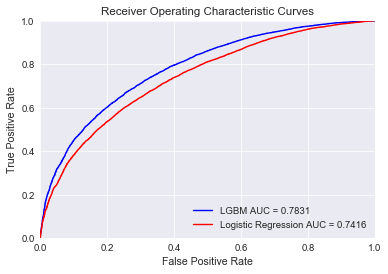

In [37]:
from sklearn import metrics

# Examine ROC curve for both models
lgbm_fpr, lgbm_tpr, _ = metrics.roc_curve(y_test, lgbm_probs[:,1])
logr_fpr, logr_tpr, _ = metrics.roc_curve(y_test, logr_probs[:,1])

plt.title('Receiver Operating Characteristic Curves')
plt.plot(lgbm_fpr, lgbm_tpr, 'b', label = 'LGBM AUC = %0.4f' % lgbm_AUC)
plt.plot(logr_fpr, logr_tpr, 'r', label = 'Logistic Regression AUC = %0.4f' % logr_AUC)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier

# Examine confusion matrices for both models and performance metrics
model_names = ['Light GBM','Logistic Regression']
model_predictions = [lgbm_test_preds, logr_test_preds]
model_AUC = [lgbm_AUC, logr_AUC]

for i in zip(model_names, model_predictions, model_AUC):
    print(i[0],'Model Evaluation:')
    print('Accuracy: {:.4f}'.format(accuracy_score(y_test, i[1])))
    print('AUC: {:.4f}'.format(i[2]))
    print('Precision: {:.4f}'.format(precision_score(y_test, i[1])))
    print('Recall: {:.4f}'.format(recall_score(y_test, i[1])))
    print('F1: {:.4f}'.format(f1_score(y_test, i[1])))
    print()

    print('Confusion Matrix:')
    print(pd.crosstab(y_test, i[1], rownames=['True'], colnames=['Predicted'], margins=True))
    print()
    
# Establish baseline with majority dummy classifier
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)

print('Accuracy of Majority classifier on test set: {:.4f}'
     .format(dummy_majority.score(X_test, y_test)))

Light GBM Model Evaluation:
Accuracy: 0.7412
AUC: 0.7831
Precision: 0.7634
Recall: 0.8852
F1: 0.8198

Confusion Matrix:
Predicted     0      1    All
True                         
0          4106   4918   9024
1          2057  15866  17923
All        6163  20784  26947

Logistic Regression Model Evaluation:
Accuracy: 0.7143
AUC: 0.7416
Precision: 0.7352
Recall: 0.8914
F1: 0.8058

Confusion Matrix:
Predicted     0      1    All
True                         
0          3271   5753   9024
1          1947  15976  17923
All        5218  21729  26947

Accuracy of Majority classifier on test set: 0.6651


In [39]:
important_features = pd.DataFrame(lgbm_feature_importance, 
                              columns=["importance"],
                              index = X_train.columns)
important_features.sort_values(by='importance',ascending=False,inplace=True)
important_features[:20]

,importance
IncidentHour,1429
IncidentMonth,1101
AvgOffenceRate,1007
IncidentWeekday,896
AvgViolentOffenceRate,808
NumTactics,426
kmodes_cluster,378
IncidentLocation: Street/Highway,228
Compliant handcuffing,217
SubjectAge: 18-34,210


In [40]:
# Examine feature important using random forests of top 20 features
rf_important_features = rf_feature_importance(X_train, y_train)[:20]
rf_important_features

,importance
IncidentHour,0.057593
IncidentMonth,0.057004
IncidentWeekday,0.048518
AvgOffenceRate,0.045121
AvgViolentOffenceRate,0.044059
kmodes_cluster,0.022987
NumTactics,0.020559
MentalDisability,0.019684
Compliant handcuffing,0.018656
MainDuty: Mobile patrol,0.015660


# Other Analysis

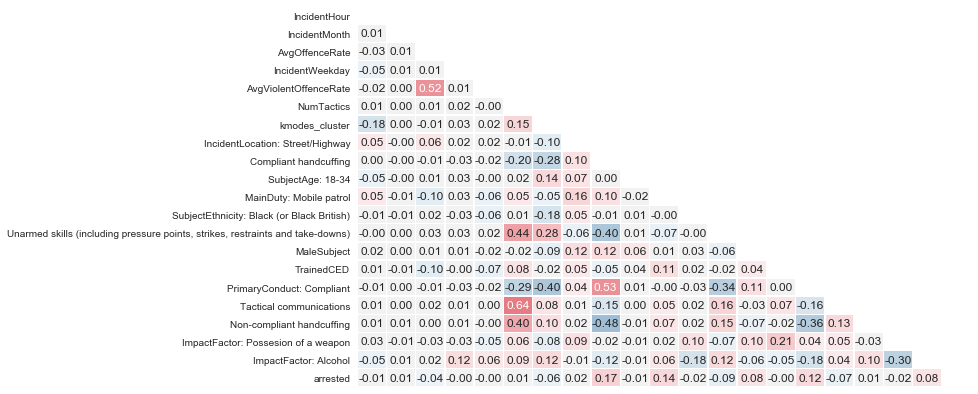

In [48]:
# Create correlation heatmap of important features and target
    # [https://seaborn.pydata.org/examples/many_pairwise_correlations.html]
import seaborn as sns

sns.set(style="white")

corr_feats = X_train[important_features[:20].index]
corr_feats['arrested'] = y_train

# Compute the correlation matrix
corr = corr_feats.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=False, linewidths=.5, annot=True, fmt=".2f", cbar=False, yticklabels = True, xticklabels = False);


In [ ]:
# Visualize MCA plot of important binary features with kmodes clusters
target = 'Arrested'
X_train, X_test, y_train, y_test = initialize_train_test(target, 0.30)
X_train, X_test, y_train, y_test, cat_encoding = data_transformation_pipeline(
    X_train, X_test, y_train, y_test, sel_cat_encoding='one-hot', remove_correlation=False,
    feature_selection=False, binary_dim_reduce='None', replace_binary_vals=False, add_kmodes=True)

binary_cols = [col for col in important_features.index if X_train[col].isin([0, 1]).all()]

X_train_viz, _ = dimensionality_reduction(X_train[binary_cols], X_test[binary_cols], 'MCA', 'DF', 2)

n = 2000
plt.figure(figsize=(8, 8))
plt.scatter(X_train_viz.iloc[0:n,0],X_train_viz.iloc[0:n,1],c= X_train['kmodes_cluster'].iloc[0:n]);